## Intro 
In this notebook we will apply knowledge gathered from bacteria famillies analysis to KEGG pathways dataset, main difference between those we can expect is higher number of features and more highly corelated data.  

### Import libraries and load data

In [5]:
#libraries import
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
# for tensorboard logs
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import normalize
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, KFold
from functions import *
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE, SMOTEN
np.random.seed(111)
tf.random.set_seed(111)

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/paq88/Fish_neural_network_classifier/refs/heads/main/sed_based/Data/sed_KEGG_paths_merged.csv')

In [7]:
print(df.shape)
df.head()

(50, 238)


,pond,ko05340,ko00564,ko00680,ko00562,ko00563,ko03030,ko00561,ko00440,ko00250,...,ko05412,ko00905,ko03015,ko05414,ko04320,ko04740,ko05214,ko04745,ko04012,ko04722
0,S8.201.Sed,2483.06,46002.51,73354.01,12921.62,55.0,52097.75,23289.22,2725.06,76990.24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,S8.202.Sed,3736.83,57196.57,102558.53,16078.17,0.0,67388.46,31995.86,3786.00,100060.80,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,S9.231.Sed,2464.17,45408.79,72940.07,12974.68,0.0,52935.25,23597.27,2433.42,76317.49,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,S9.232.Sed,5169.91,53418.09,98344.53,15092.31,0.0,65909.03,29807.71,3249.49,98762.58,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,S10.222.Sed,1532.00,26319.19,46407.43,7309.02,0.0,32166.21,14235.97,1371.59,48799.16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
ID = df['pond'].str.split('.').apply(lambda x: x[1] if len(x) > 1 else None)
df.insert(1, 'ID', ID)

In [9]:
df.sort_values('ID', inplace=True)

In [10]:
predictors = df.columns[2:]
print(f"number of predictors/bacteria famillies: {len(predictors)}")

# replacing NaN values with 0
df.fillna(0, inplace=True)

df.head()



number of predictors/bacteria famillies: 237


,pond,ID,ko05340,ko00564,ko00680,ko00562,ko00563,ko03030,ko00561,ko00440,...,ko05412,ko00905,ko03015,ko05414,ko04320,ko04740,ko05214,ko04745,ko04012,ko04722
0,S8.201.Sed,201,2483.06,46002.51,73354.01,12921.62,55.0,52097.75,23289.22,2725.06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,S8.202.Sed,202,3736.83,57196.57,102558.53,16078.17,0.0,67388.46,31995.86,3786.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,S14.203.Sed,203,1981.65,34767.88,53110.90,10947.29,0.0,39051.04,18265.41,2046.82,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,S14.204.Sed,204,2449.32,48040.43,84004.08,12796.85,0.0,56249.04,25634.66,2413.32,...,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0
21,S18.205.Sed,205,3223.75,58863.78,92218.54,16609.16,20.0,65939.93,29358.10,3393.33,...,10.0,0.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0


In [11]:
timepoint = np.tile([0, 1], 25)
df.insert(1, 'timepoint', timepoint)

In [13]:
# for normalisation we will use starndard min-max normalisation
df[predictors] = normalize(df[predictors], norm='max', axis=0, copy=True, return_norm=False)
df.describe()

,timepoint,ko05340,ko00564,ko00680,ko00562,ko00563,ko03030,ko00561,ko00440,ko00250,...,ko05412,ko00905,ko03015,ko05414,ko04320,ko04740,ko05214,ko04745,ko04012,ko04722
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.500000,0.427981,0.489505,0.498134,0.559149,0.030909,0.506057,0.540151,0.490196,0.531252,...,0.065455,0.081739,0.055135,0.080000,0.065455,0.027500,0.027500,0.027500,0.027500,0.027500
std,0.505076,0.204134,0.197568,0.194754,0.217259,0.151018,0.196681,0.212624,0.228835,0.203750,...,0.236663,0.212934,0.169793,0.254194,0.236663,0.150021,0.150021,0.150021,0.150021,0.150021
min,0.000000,0.052225,0.052410,0.052397,0.061102,0.000000,0.050122,0.055485,0.063806,0.052093,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.298748,0.355653,0.384165,0.421461,0.000000,0.390621,0.408219,0.311749,0.414260,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.390221,0.476028,0.500701,0.541827,0.000000,0.484009,0.519813,0.482618,0.515067,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.505913,0.616061,0.618313,0.697781,0.000000,0.624554,0.679154,0.630388,0.661848,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000




| number | setup | pond numbers | water supplementation | feed supplementation |
|---|---|---|---|---|
|0|control | 8,14,18,24,29|NO|NO|
|1|set 1 | 12,16,19,23,26|Em farma|NO|
|2|set 2 | 10,21,28,30,32|Em farma|EM|
|3|set 3 | 9,13,17,20,27|EM|NO|
|4|set 4 | 11,15,22,25,31|EM|EM|

In [14]:
df['pond_org'] = df['pond']

C:\Users\marek\AppData\Local\Temp\ipykernel_27848\3039816547.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['pond_org'] = df['pond']


In [15]:
# Decoding use pond decoder 2 for this

codes = {0 : [8,14,18,24,29], 1: [12,16,19,23,26], 2 : [10,21,28,30,32], 3 : [9,13,17,20,27], 4 : [11,15,22,25,31]}

df['pond']=df['pond_org'].apply(lambda x: pond_decoder_2(x, codes))


In [16]:
df['pond'].value_counts()

pond
0    10
1    10
2    10
3    10
4    10
Name: count, dtype: int64

In [17]:
df.head()

,pond,timepoint,ID,ko05340,ko00564,ko00680,ko00562,ko00563,ko03030,ko00561,...,ko00905,ko03015,ko05414,ko04320,ko04740,ko05214,ko04745,ko04012,ko04722,pond_org
0,0,0,201,0.480291,0.616735,0.600233,0.695639,1.000000,0.613798,0.653411,...,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,S8.201.Sed
1,0,1,202,0.722804,0.766809,0.839204,0.865572,0.000000,0.793949,0.897688,...,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,S8.202.Sed
12,0,0,203,0.383305,0.466118,0.434590,0.589350,0.000000,0.460086,0.512461,...,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,S14.203.Sed
13,0,1,204,0.473765,0.644057,0.687379,0.688922,0.000000,0.662708,0.719216,...,0.0,0.00000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,S14.204.Sed
21,0,0,205,0.623560,0.789161,0.754595,0.894158,0.363636,0.776882,0.823682,...,0.0,0.27027,0.833333,0.909091,0.0,0.0,0.0,0.0,0.0,S18.205.Sed


In [18]:
# defragmenting 
df = df.copy()

In [20]:
df['pondXtime'] = df['pond'].astype(str) + '_' + df['timepoint'].astype(str)    

In [23]:
df['pondXtime'].value_counts()

pondXtime
0_0    5
0_1    5
1_0    5
1_1    5
2_0    5
2_1    5
3_0    5
3_1    5
4_0    5
4_1    5
Name: count, dtype: int64

In [24]:
train_val_df, test_df = train_test_split(df, test_size= 10, random_state=111, stratify=df['pondXtime'])
print(train_val_df.shape, test_df.shape)

(40, 242) (10, 242)


### Definitions

In [25]:
kf = KFold(n_splits=5, shuffle=True, random_state=111)


In [26]:
# early stopping callback to save the best model weights for test set
es_callback = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=100,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Verbosity mode
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

### Modelling timepoints only
We will start with what worked best for previous datasets.


In [27]:
model1 = keras.Sequential()



model1.add(keras.layers.Dense(128,input_shape=(len(predictors),),activation='relu'))


model1.add(keras.layers.Dropout(rate=0.25))
model1.add(keras.layers.Dense(64, activation ='relu'))
model1.add(keras.layers.Dense(16, activation ='relu'))
model1.add(keras.layers.Dropout(rate=0.25))
model1.add(keras.layers.Dense(16, activation ='relu'))

model1.add(keras.layers.Dense(2, activation ='softmax'))

print(model1.summary())


loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model1.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        30,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,066 (156.51 KB)

 Trainable params: 40,066 (156.51 KB)

 Non-trainable params: 0 (0.00 B)

None


Number of classes: 2
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9000 - loss: 0.1014
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
predicted classes:       [0 0 0 1 0 1 1 0 1 0]
true validation classes: [0 0 1 1 0 1 1 0 1 0]
mean confidence score: 77435.3593, sd confidence score: 128545.9449
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9000 - loss: 0.1696
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
predicted classes:       [1 0 1 1 1 1 0 0 1 1]
true validation classes: [1 0 1 1 1 1 0 0 1 0]
mean confidence score: 40717.0549, sd confidence score: 116840.148
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0105
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted classes:       [1 0 0 1 1 0 1 0 1 1]
true validation classes: [1 0 0 1 1 0 1 0 1 1]
mean confidence score: 58571088.3348, sd confidence score: 175419515.2892
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8000 - loss: 0.53

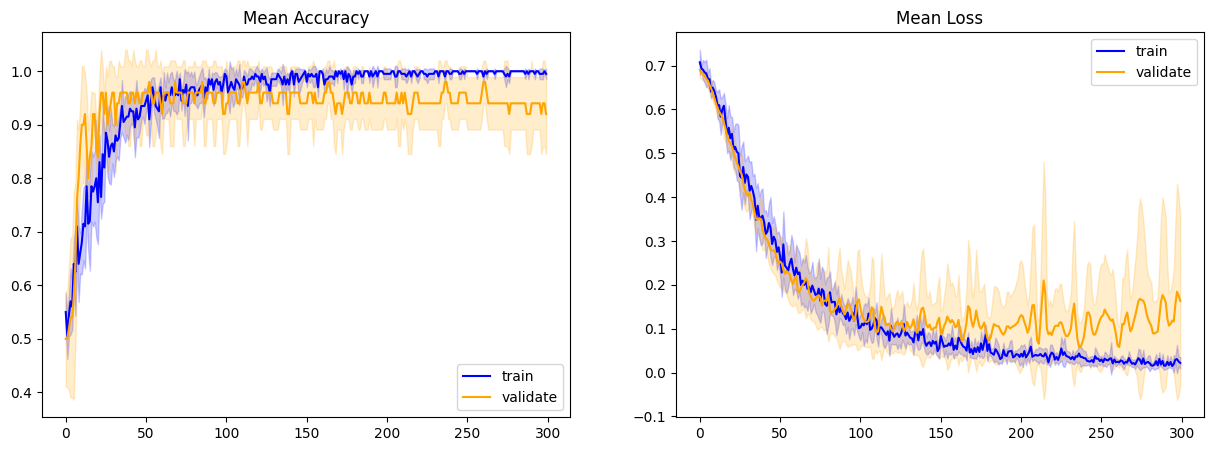

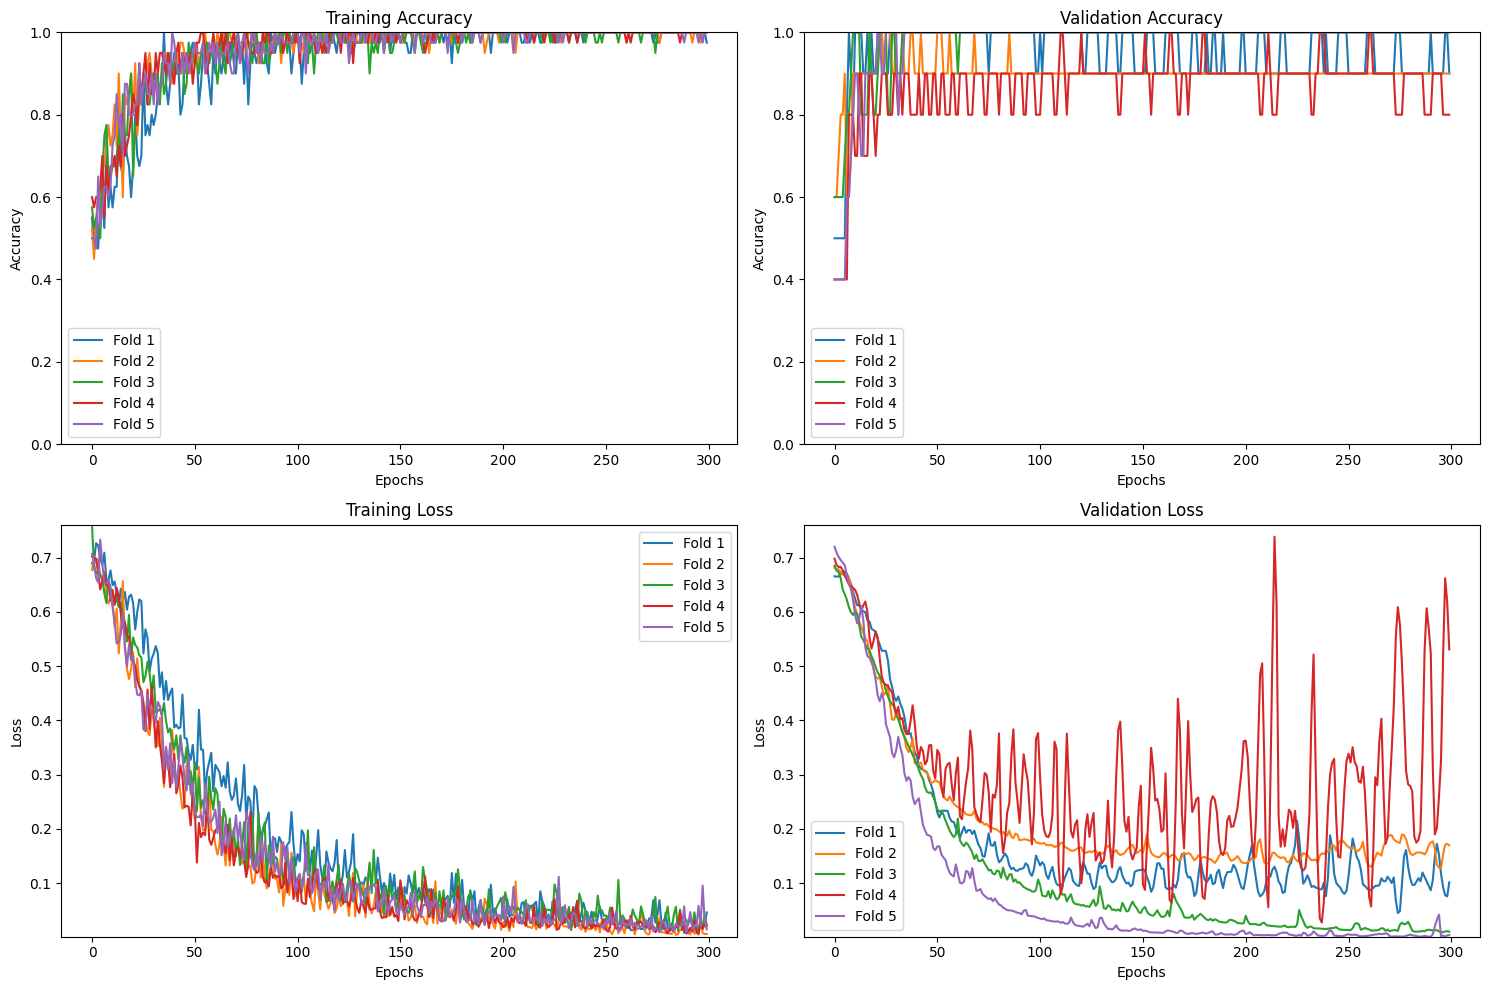

In [28]:
crossvalidate(df, model1, predictors, 'timepoint', kf)

We can see the results are the same as for bacteria dataset, with high mean accuracy of timepoints classsification.

### Oversampling all of the classes in 5 class classification for both timepoints


In [29]:
train_val_df.shape, test_df.shape

((40, 242), (10, 242))

In [30]:
empty_class = pd.DataFrame(0, index=range(40),columns=train_val_df.columns)
#empty_class[] = np.random.rand(40, empty_class.shape[1])
empty_class['pond'] = 9


In [31]:
train_val_df_empty_class = pd.concat([train_val_df, empty_class], axis=0)

In [32]:
smote = SMOTE(random_state=111)
X = train_val_df_empty_class[predictors].values
y = train_val_df_empty_class['pond']

In [33]:
X.shape, y.shape

((80, 237), (80,))

In [34]:
X_smote, y_smote = smote.fit_resample(X, y)
y_smote.shape

(240,)

In [35]:
df_smote = pd.concat([pd.DataFrame(X_smote, columns=predictors), pd.DataFrame(y_smote, columns=['pond'])], axis=1)
df_smote_cleared = df_smote[df_smote['pond'] != 9]
df_smote_cleared.reset_index(drop=True, inplace=True)
print(df_smote_cleared.shape)
df_smote_cleared['pond'].value_counts()

(200, 238)


pond
2    40
1    40
4    40
3    40
0    40
Name: count, dtype: int64

(80, 237) (80,)
(240, 237) (240,)
Number of classes: 5
training for 1 subset


C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.3432  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
predicted classes:       [2 4 4 0 1 0 0 1 3 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 4 4 4 4
 4 4 4]
true validation classes: [2 4 4 0 1 0 0 1 3 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 4 4 4 4
 4 4 4]
mean confidence score: 14.1792, sd confidence score: 11.0187
training for 2 subset
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8958 - loss: 0.4615 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
predicted classes:       [4 3 3 2 0 1 0 1 4 0 1 0 0 0 1 1 2 1 1 1 1 2 2 2 2 2 3 3 3 3 3 3 4 3 4 4 1
 4 4 1]
true validation classes: [4 3 3 2 0 1 0 1 4 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 3 3 3 4 4 4
 4 4 4]
mean confidence score: 12.0645, sd confidence score: 13.7878
training for 3 subset
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9187 - loss: 0.4688 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
predicted classes:       [3 3 3 3 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2

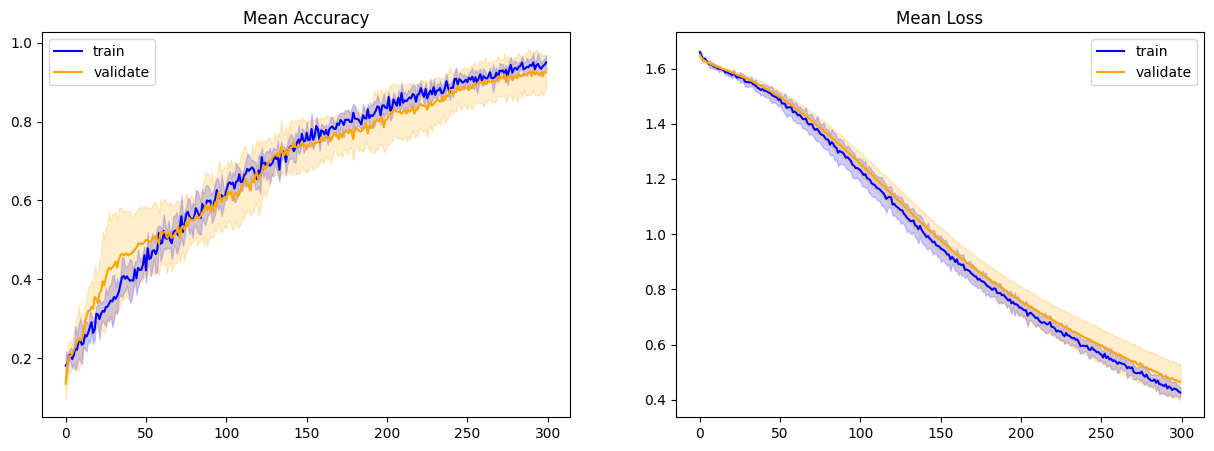

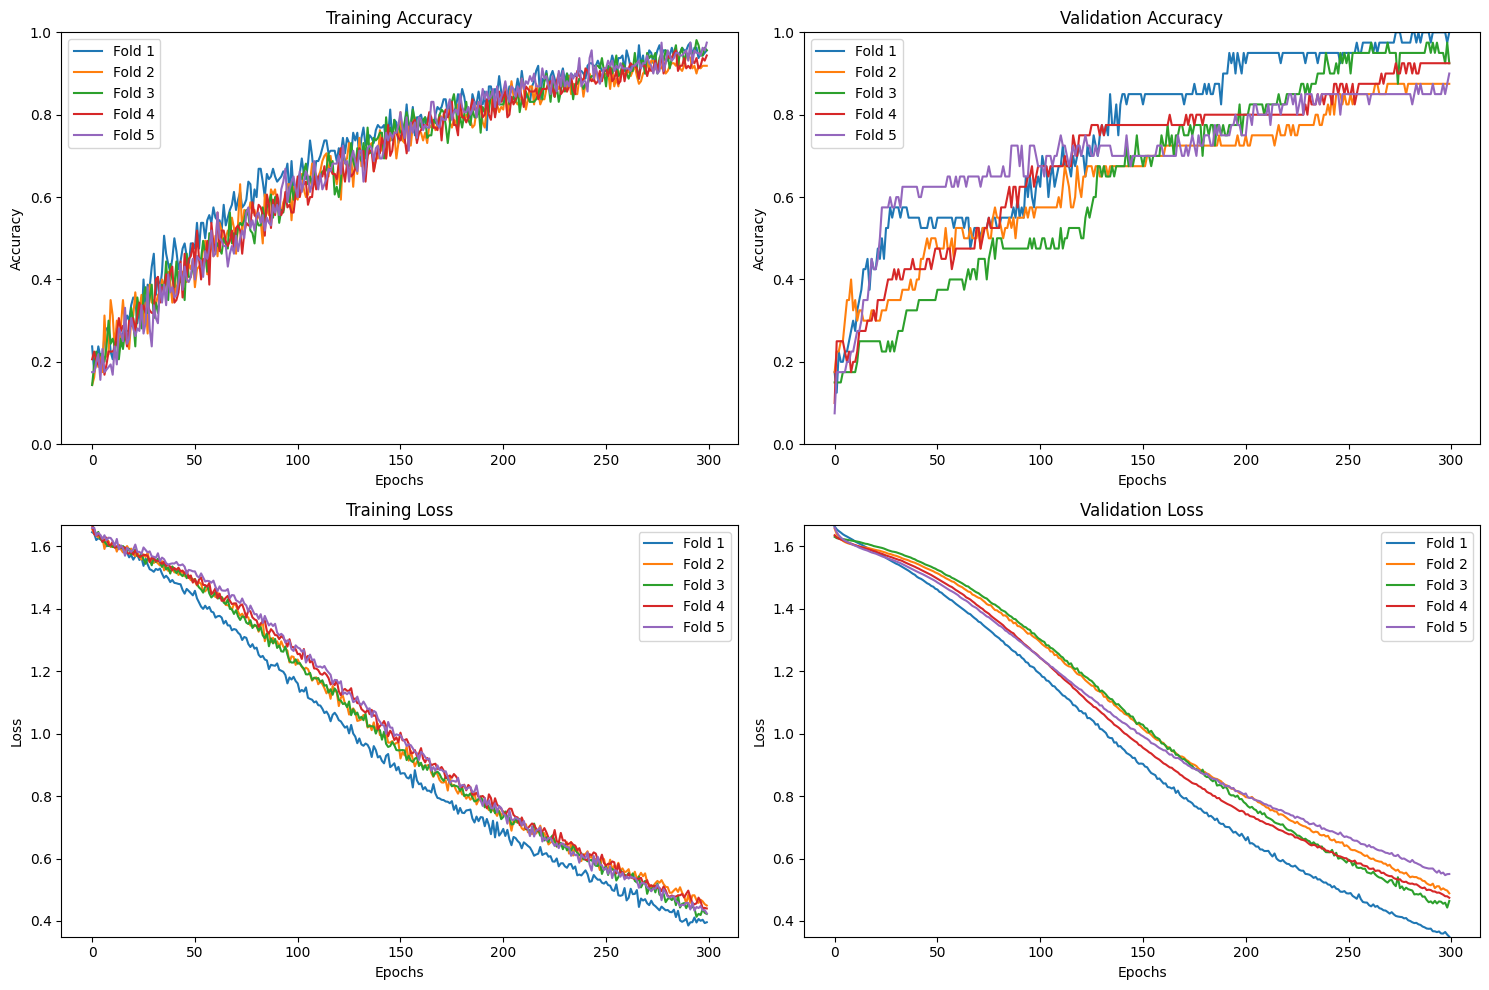

In [36]:
print(X.shape, y.shape)
print(X_smote.shape, y_smote.shape)

model3 = keras.Sequential()
model3.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))
model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(64, activation ='sigmoid'))
model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(16, activation ='sigmoid'))
model3.add(keras.layers.Dense(5, activation ='softmax'))

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model3.compile(optimizer = optimizer, loss = loss, metrics=metrics)
crossvalidate(df_smote_cleared, model3, predictors, 'pond', kf)

In [37]:
X = df_smote_cleared[predictors].values
y = keras.utils.to_categorical(df_smote_cleared['pond'].values)
y_test = keras.utils.to_categorical(test_df['pond'].values)
X_test = test_df[predictors].values
reset_weights(model3)   

history5 = model3.fit(X, y, epochs=300, batch_size=5,validation_data=(X_test, y_test), verbose=1, callbacks=[es_callback])

Epoch 1/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1991 - loss: 1.6459 - val_accuracy: 0.2000 - val_loss: 1.6465
Epoch 2/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2404 - loss: 1.6331 - val_accuracy: 0.2000 - val_loss: 1.6360
Epoch 3/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2105 - loss: 1.6318 - val_accuracy: 0.2000 - val_loss: 1.6302
Epoch 4/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2158 - loss: 1.6265 - val_accuracy: 0.2000 - val_loss: 1.6257
Epoch 5/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2450 - loss: 1.6131 - val_accuracy: 0.2000 - val_loss: 1.6222
Epoch 6/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2006 - loss: 1.6124 - val_accuracy: 0.2000 - val_loss: 1.6194
Epoch 7/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1916 - loss: 1.6164 - val_accuracy: 0.2000 - val_loss: 1.6166
Epoch 8/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2714 - loss: 1.5980 - val_accuracy: 0.2000 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1000 - loss: 1.6004
[1.6003717184066772, 0.10000000149011612]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted values: [1 1 3 2 2 1 0 3 1 0]
True values: [3 1 4 0 3 2 2 1 0 4]


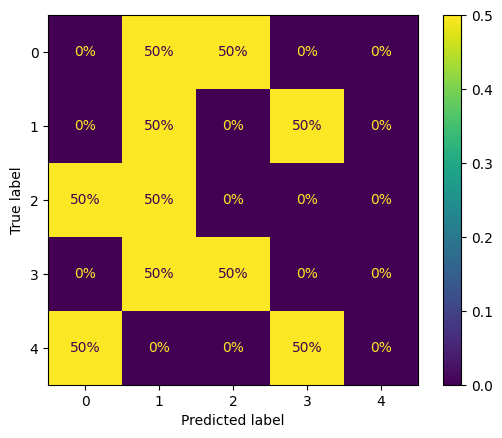

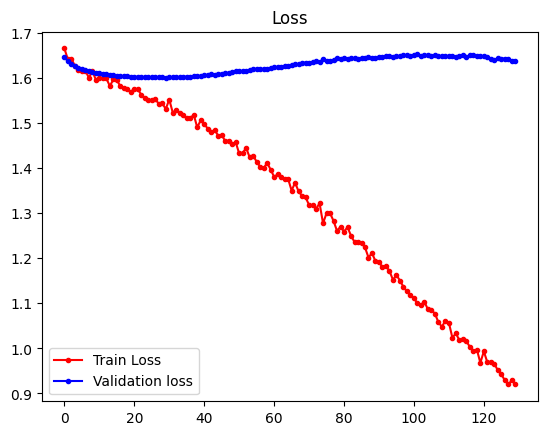

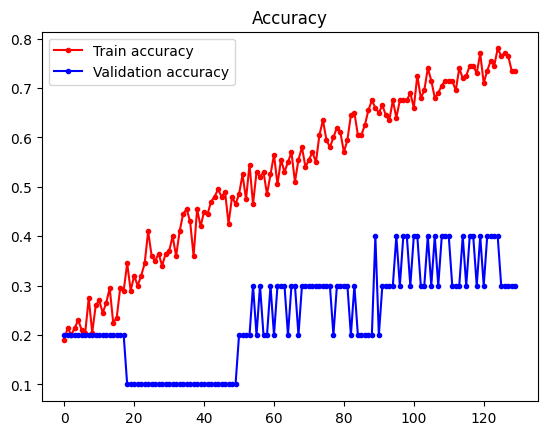

In [38]:
evaluate_model(model3, history5, X_test, y_test)

For modeling oversampled KEGG paths dataset we have a bit different results than for previous two. We can note that the results for validation subset are much worse. Nevertheless end results on test dataset were very poor. 

## XGBoost Comparison
As for previous datasets we will perform Comparison to XGBoost

In [39]:
import xgboost as xgb

In [40]:
X_train = train_val_df[predictors].values
X_test = test_df[predictors].values


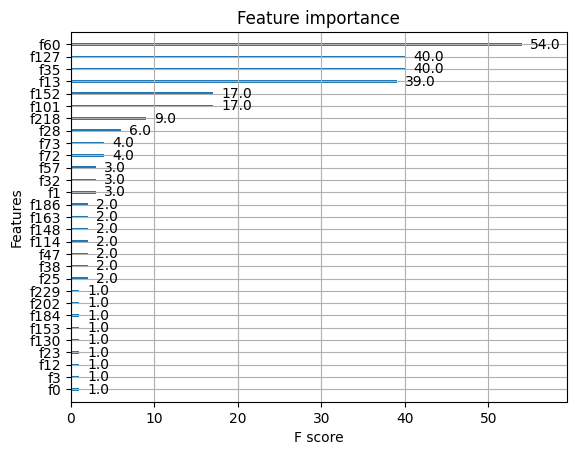

In [41]:
dtrain = xgb.DMatrix(X_train, label=train_val_df['timepoint'])
dtest = xgb.DMatrix(X_test, label=test_df['timepoint'])
params = {
    'objective': 'multi:softmax',
    'num_class': 5,
    'max_depth': 3, # maximum deepth of the tree, used to controll complexity of the model
    'eta': 0.1,
    'seed': 111

}
bst2 = xgb.train(params, dtrain, 1000, num_boost_round=100)

xgb.plot_importance(bst2)
xgb_pred = bst2.predict(dtest)
xgb_acc = accuracy_score(test_df['timepoint'], xgb_pred)

[0 0 1 0 1 1 0 1 1 0]
[0. 0. 1. 0. 1. 1. 0. 1. 1. 0.]
1.0


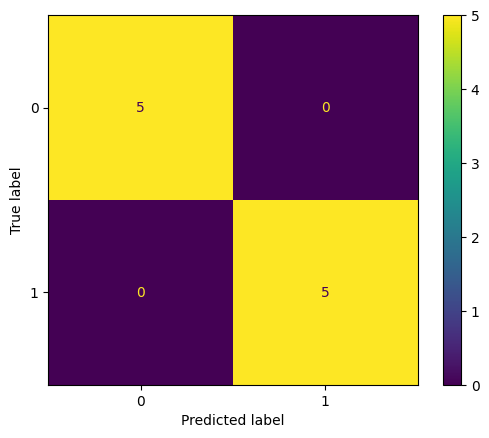

In [42]:
print(test_df['timepoint'].values)
print(xgb_pred)
print(xgb_acc)

cm = confusion_matrix(test_df['timepoint'].values, xgb_pred)
ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot()

### Classyfing only ponds for both timepoints

In [43]:
dtrain = xgb.DMatrix(X_train, label=train_val_df['pond'].values)  
dtest = xgb.DMatrix(X_test, label=test_df['pond'].values)


bst2 = xgb.train(params, dtrain, num_boost_round=100)

xgb_pred = bst2.predict(dtest)
xgb_acc = accuracy_score(test_df['pond'].values, xgb_pred)

[3 1 4 0 3 2 2 1 0 4]
[1. 1. 4. 2. 3. 1. 2. 4. 2. 2.]
0.4


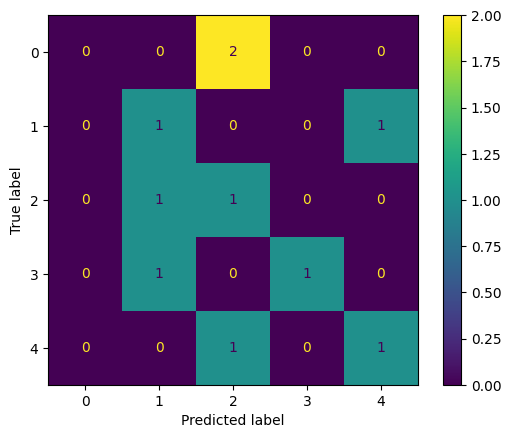

In [44]:
print(test_df['pond'].values)
print(xgb_pred)
print(xgb_acc)

cm = confusion_matrix(test_df['pond'].values, xgb_pred)
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3,4]).plot()

### Modeling ponds in first timepoint only

In [45]:
df_first_tp = df[df['timepoint'] == 0]
print(df_first_tp.shape)
df1tp_train, df1tp_test = train_test_split(df_first_tp, test_size=5, random_state=111, stratify=df_first_tp['pond'])
X_2_train = df1tp_train[predictors].values
X_2_test = df1tp_test[predictors].values

(25, 242)


In [46]:
dtrain = xgb.DMatrix(X_2_train, label=df1tp_train['pond'].values)
dtest = xgb.DMatrix(X_2_test, label=df1tp_test['pond'].values)
bst3_1 = xgb.train(params, dtrain, num_boost_round=100)

xgb_pred = bst3_1.predict(dtest)
xgb_acc = accuracy_score(df1tp_test['pond'].values, xgb_pred)

[2 4 1 0 3]
[3. 4. 3. 2. 3.]
0.4


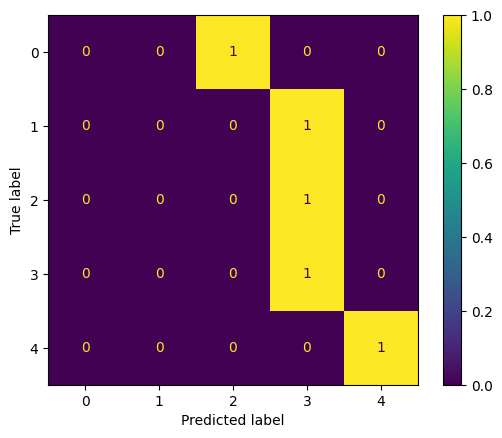

In [48]:
print(df1tp_test['pond'].values)
print(xgb_pred)
print(xgb_acc)

cm = confusion_matrix(df1tp_test['pond'].values, xgb_pred)
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3,4]).plot()

### Modeling ponds in second timepeoint only

In [49]:
df_second_tp = df[df['timepoint'] == 1]
df_second_tp.shape

df_2tp_train, df_2tp_test = train_test_split(df_second_tp, test_size=5, random_state=111, stratify=df_second_tp['pond'])
print(df_2tp_train.shape, df_2tp_test.shape)
X_2_train = df_2tp_train[predictors].values
y_2_train = df_2tp_train['pond'].values
X_2_test = df_2tp_test[predictors].values
y_2_test = df_2tp_test['pond'].values


(20, 242) (5, 242)


In [50]:
dtrain = xgb.DMatrix(X_2_train, label=y_2_train)  
dtest = xgb.DMatrix(X_2_test, label=y_2_test)
params = {
    'objective': 'multi:softmax',
    'num_class': 5,
    'max_depth': 3, # maximum deepth of the tree, used to controll complexity of the model
    'eta': 0.1,
    'seed': 111

}

bst3 = xgb.train(params, dtrain, num_boost_round=100)

xgb_pred = bst3.predict(dtest)
xgb_acc = accuracy_score(y_2_test, xgb_pred)

[2 4 1 0 3]
[1. 1. 4. 1. 4.]
0.0


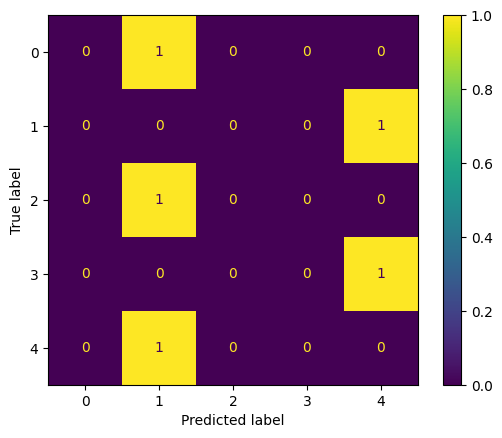

In [51]:
print(y_2_test)
print(xgb_pred)
print(xgb_acc)

cm = confusion_matrix(y_2_test, xgb_pred)
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3,4]).plot()

## Conclusions from XGBoost for KEGG pathways dataset 
We can note similar conclusions as for previous datasets, we have perfect results for modeling timepoints and quite poor altough insignifacntly better than NN's for the rest. Overall it seems that analysis the only detectable differenes in Sediment dataset are between timepoints and added probiotics didnt change microbiome structure enough.